# COVID-19 testing by country (Python)

 - Task 1: Get a COVID-19 pandemic Wiki page using HTTP request
 - Task 2: Extract COVID-19 testing data table from the wiki HTML page
 - Task 3: Pre-process and export the extracted data frame
 - Task 4: Get a subset of the extracted data frame
 - Task 5: Calculate worldwide COVID testing positive ratio
 - Task 6: Get a sorted name list of countries that reported their testing data
 - Task 7: Identify country names with a specific pattern
 - Task 8: Pick two countries you are interested in, and then review their testing data
 - Task 9: Compare which one of the selected countries has a larger ratio of confirmed cases to population
 - Task 10: Find countries with confirmedcases to population ratio rate less than a threshold


In [27]:
# Libraries

import numpy as np
import pandas as pd

import re

import plotnine as gg

import requests as rq
import xml.etree.ElementTree as et

from io import StringIO
from bs4 import BeautifulSoup as bs
from skimpy import clean_columns

In [28]:
# Page dl helper
def pdl(url, *, timeout=10, session=None):

    """
    The helper downloads the target URL.

    All parameters after * must be passed by keyword, not positionally.

    For a persistent session, define session = rq.Session() and pass it to the fn.
    """

    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0 Safari/537.36"
        ),
        "Accept": (
            "text/html,application/xhtml+xml,application/xml;"
            "q=0.9,*/*;q=0.8"
        ),
        "Accept-Language": "en-GB,en;q=0.9",
        
        "Accept-Encoding": "gzip, deflate, br",
        "DNT": "1",
        "Connection": "keep-alive",
        "Upgrade-Insecure-Requests": "1",
        "Referer": "https://www.google.com/",
    }

    try:
        client = session if session is not None else rq # session.get(url, ...) or rq.get(url, ...)
        resp = client.get(url, headers=headers, timeout=timeout)
        resp.raise_for_status() # requests.HTTPError if status code 4xx/5xx
        return resp
    except rq.RequestException as e:
        print(f"Page not downloaded:\nURL: {url} ({e})")
        return None


## Tasks 1 through 4

In [29]:
# URL
    # Template page
url1 = r"https://en.wikipedia.org/w/index.php?title=Template:COVID-19_testing_by_country"
    # Current page
url2 = r"https://en.wikipedia.org/wiki/COVID-19_testing"

Direct download. (Avoid repeated downloads lest you get caught out.)

```Python
# Download the page
wiki_page = pdl(url2)

# Extract the tab
html = bs(wiki_page.text, "html.parser") # pd.read_html(wiki_page.text)
div = html.find("div", class_="COVID-19_testing_by_country")
df = pd.read_html(StringIO(str(div)))[0]
df.head()
```

In [30]:
# Load up the local file
with open("m5_covid-19.html", "r", encoding="utf-8") as f:
    html = bs(f, "html.parser")

In [31]:
# Extract the table
div = html.find("div", class_="COVID-19_testing_by_country")
df = pd.read_html(StringIO(str(div)))[0]

df.head()

,Country or region,Date[a],Tested,Units[b],Confirmed (cases),"Confirmed / tested, %","Tested / population, %","Confirmed / population, %",Ref.
0,Afghanistan,17 Dec 2020,154767,samples,49621,32.1,0.40,0.13,[248]
1,Albania,18 Feb 2021,428654,samples,96838,22.6,15.0,3.4,[249]
2,Algeria,2 Nov 2020,230553,samples,58574,25.4,0.53,0.13,[250][251]
3,Andorra,23 Feb 2022,300307,samples,37958,12.6,387,49.0,[252]
4,Angola,2 Feb 2021,399228,samples,20981,5.3,1.3,0.067,[253]


In [32]:
# Clean-up
    # Clean col names
df = clean_columns(df)
df = df.rename(columns={"date_a": "date", "units_b": "units"})

pc_cols = [c for c in df.columns if c.endswith("%")]
pc_cols2 = [re.sub("%", "percent", c) for c in pc_cols]
pc_map = dict(zip(pc_cols, pc_cols2))

df = df.rename(columns=pc_map)

In [33]:
    # Format dates
df["date"] = pd.to_datetime(df["date"], format="%d %b %Y", errors="coerce")

    # Filter out footnotes
df = df.loc[~ df["date"].isna(),:]

    # Format numeric cols
num_cols = [c for c in df.columns if "tested" in c or "confirmed" in c]
df[num_cols] = df[num_cols].astype("float")

    # Clean up entity names
df["country_or_region"] = df["country_or_region"].replace(regex=r"\[.*?\]", value="")

df.sample(10)

,country_or_region,date,tested,units,confirmed_cases,confirmed_tested_percent,tested_population_percent,confirmed_population_percent,ref
90,Lebanon,2021-06-14,4599186.0,samples,542649.0,11.80,67.4,8.00,[346]
122,Oman,2020-10-28,509959.0,samples,114434.0,22.40,11.0,2.50,[383]
163,United Arab Emirates,2023-02-01,198685717.0,samples,1049537.0,0.53,2070.0,10.90,[429]
64,Guatemala,2023-01-06,6800560.0,samples,1230098.0,18.10,39.4,7.10,[320]
84,Kenya,2021-03-05,1322806.0,samples,107729.0,8.10,2.8,0.23,[340]
162,Ukraine,2021-11-24,15648456.0,samples,3367461.0,21.50,37.2,8.00,[428]
72,India,2022-07-08,866177937.0,samples,43585554.0,5.00,63.0,31.70,[328][329]
93,Libya,2022-04-14,2578215.0,samples,501862.0,19.50,37.6,7.30,[250][349]
67,Guyana,2022-06-15,648569.0,cases,66129.0,10.20,82.5,8.40,[323]
34,Colombia,2022-11-24,36875818.0,samples,6314769.0,17.10,76.4,13.10,[286][287]


In [34]:
# Dimension check
d = df.shape

print(f"{d[0]} rows and {d[1]} cols.")

172 rows and 9 cols.


## Task 5: Calculate worldwide COVID testing positive ratio

### Global ratio

In [35]:
# Global confirmed / tested ratio
confirmed_tested = df["confirmed_cases"].sum() / df["tested"].sum()

print("Percentage of all tested confirmed positive:\n", round(confirmed_tested * 100, 2))

Percentage of all tested confirmed positive:
 7.99


### Country-specific ratios

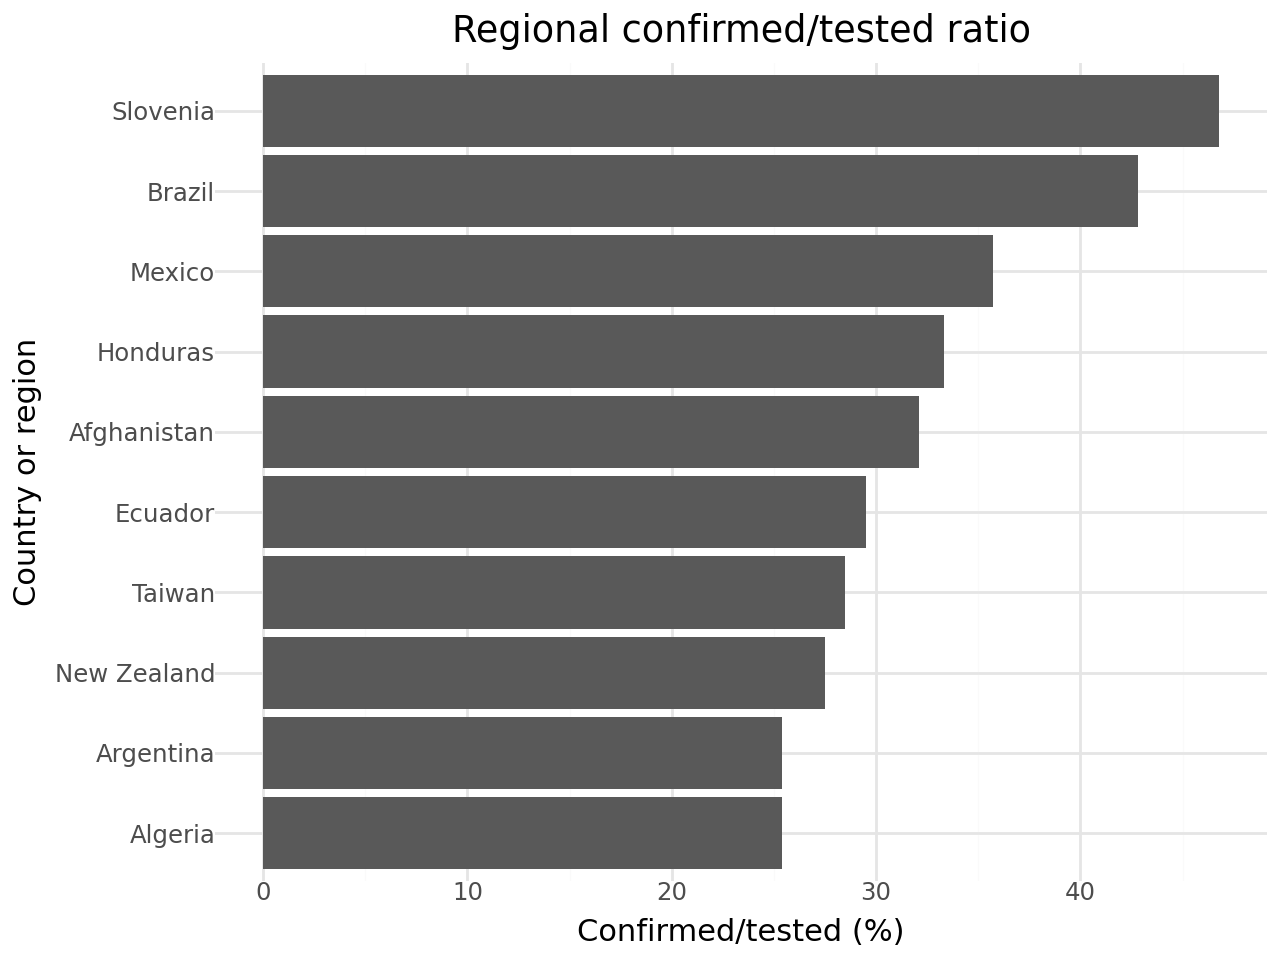

In [36]:
# Top 10 confirmed/tested ratio per country
gg_df1 = df.copy()
gg_df1 = gg_df1.sort_values("confirmed_tested_percent", ascending=False)
gg_df1 = gg_df1.iloc[range(10)]

    # Construct a factor for ggplot
gg_df1["country_or_region"] = pd.Categorical(
    gg_df1["country_or_region"], 
    categories=gg_df1["country_or_region"].tolist()[::-1],
    ordered=True
)

(
    gg.ggplot(gg_df1, mapping = gg.aes(x="country_or_region", y="confirmed_tested_percent")) +
    gg.geom_bar(stat="identity") + 
    gg.coord_flip() + 
    gg.theme_minimal() +
    gg.labs(
        title="Regional confirmed/tested ratio",
        x="Country or region", 
        y="Confirmed/tested (%)"
    )
)

## Task 6: Get a sorted name list of countries that reported their testing data

In [37]:
# Sort the df alphabetically in the descending order
df.sort_values("country_or_region", ascending=False).head()

,country_or_region,date,tested,units,confirmed_cases,confirmed_tested_percent,tested_population_percent,confirmed_population_percent,ref
171,Zimbabwe,2022-10-15,2529087.0,samples,257893.0,10.2,17.0,1.70,[250][438]
170,Zambia,2022-03-10,3301860.0,samples,314850.0,9.5,19.0,1.80,[437]
169,Vietnam,2022-08-28,45772571.0,samples,11403302.0,24.9,46.4,11.60,[436]
168,Venezuela,2021-03-30,3179074.0,samples,159149.0,5.0,11.0,0.55,[435]
167,Uzbekistan,2020-09-07,2630000.0,samples,43975.0,1.7,7.7,0.13,[434]


## Task 7: Identify countries names with a specific pattern

In [40]:
# Find every united entity
united_df = df.copy()
united_df = united_df[united_df["country_or_region"].str.lower().str.contains("united", na=False)]

united_df

,country_or_region,date,tested,units,confirmed_cases,confirmed_tested_percent,tested_population_percent,confirmed_population_percent,ref
163,United Arab Emirates,2023-02-01,198685717.0,samples,1049537.0,0.53,2070.0,10.9,[429]
164,United Kingdom,2022-05-19,522526476.0,samples,22232377.0,4.30,774.0,32.9,[430]
165,United States,2022-07-29,929349291.0,samples,90749469.0,9.80,281.0,27.4,[431][432]


## Task 8: Pick two countries you are interested, and then review their testing data

In [45]:
# Subset the df to compare two countries
c1 = df.copy().loc[df["country_or_region"] == "Venezuela",:]
c2 = df.copy().loc[df["country_or_region"] == "Greenland",:]

pd.concat([c1, c2], axis=0)

,country_or_region,date,tested,units,confirmed_cases,confirmed_tested_percent,tested_population_percent,confirmed_population_percent,ref
168,Venezuela,2021-03-30,3179074.0,samples,159149.0,5.0,11.0,0.55,[435]
62,Greenland,2022-01-30,164573.0,samples,10662.0,6.5,293.0,19.00,[318]


## Task 9: Compare which one of the selected countries has a larger ratio of confirmed cases to population

In [53]:
# Use a conditional statement to identify the country with the higher confirmed/tested ratio
if c1.confirmed_population_percent.iloc[0] > c2.confirmed_population_percent.iloc[0]:
    country = c1.country_or_region.iloc[0]
    ratio = c1.confirmed_population_percent.iloc[0]
else:
    country = c2.country_or_region.iloc[0]
    ratio = c2.confirmed_population_percent.iloc[0]

print(country, "has a higher ratio of confirmed cases per head, viz.", ratio, "%.")

Greenland has a higher ratio of confirmed cases per head, viz. 19.0 %.


## Task 10: Find countries with confirmed to population ratio rate less than a threshold

In [54]:
# Get a subset of any countries with confirmed/population ratio less than the threshold
df[df["confirmed_population_percent"] < 0.01]

,country_or_region,date,tested,units,confirmed_cases,confirmed_tested_percent,tested_population_percent,confirmed_population_percent,ref
27,Burundi,2021-01-05,90019.0,NaN,884.0,0.980,0.7600,0.00740,[279]
33,China,2020-07-31,160000000.0,cases,87655.0,0.055,11.1000,0.00610,[284][285]
88,Laos,2021-03-01,114030.0,cases,45.0,0.039,1.6000,0.00063,[344]
118,North Korea,2020-11-25,16914.0,cases,0.0,0.000,0.0660,0.00000,[378]
155,Tanzania,2020-11-18,3880.0,NaN,509.0,13.100,0.0065,0.00085,[250]
